# Create Zarr Pyramid

In this notebook, we create a Zarr pyramid store for the CMIP6 TAS daily data available in NetCDF on S3. We use the ndpyramid library from carbonplan. This library offers either the `pyramid_coarsen` method of aggregating data or the `pyramid_reproject` method. The `pyramid_reproject` method reprojects data to different dimensions, which usually correspond to different zoom levels when visualizing the data on a map.

## 1.1 Install and import libraries

In [1]:
from carbonplan_data.utils import set_zarr_encoding
from carbonplan_data.metadata import get_cf_global_attrs
import eodc_hub_role
import fsspec
from ndpyramid import pyramid_reproject
import s3fs
import xarray as xr

ModuleNotFoundError: No module named 'carbonplan_data'

In [4]:
!pip install -r ../requirements.txt

  Cloning https://github.com/carbonplan/cmip6-downscaling.git to /tmp/pip-req-build-8k283hkd
  Running command git clone --filter=blob:none --quiet https://github.com/carbonplan/cmip6-downscaling.git /tmp/pip-req-build-8k283hkd
  Resolved https://github.com/carbonplan/cmip6-downscaling.git to commit 880928aecd66cb484176fdecea8dff31b39c6fdb
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/pangeo-forge/pangeo-forge-recipes.git (to revision beam-refactor) to /tmp/pip-req-build-yhvt8eq2
  Running command git clone --filter=blob:none --quiet https://github.com/pangeo-forge/pangeo-forge-recipes.git /tmp/pip-req-build-yhvt8eq2
  Running command git checkout -b beam-refactor --track origin/beam-refactor
  Switched to a new branch 'beam-refactor'
  Branch 'beam-refactor' set up to track remote branch 'beam-refactor' from 'origin'.
  Resolved https://github.com/pangeo-forge/pangeo-f

In [3]:
credentials = eodc_hub_role.fetch_and_set_credentials()
bucket = 'nasa-eodc-data-store'

Note: This is adapted from https://github.com/carbonplan/benchmark-maps/blob/datasets/stores/01b_cmip6_netcdf_to_zarr.ipynb.

## 1.2 Set parameters

In [4]:
#parameters
temporal_resolution = "daily"
model = "GISS-E2-1-G"
variable = "tas"
anon=True

In [7]:
# Initiate fsspec filesystems for reading and writing
s3_path = f"s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/{model}/historical/r1i1p1*/{variable}/*"
fs_read = fsspec.filesystem("s3", anon=anon, skip_instance_cache=False)
fs_write = fsspec.filesystem("")

In [13]:
# Retrieve list of available months
file_paths = fs_read.glob(s3_path)
print(f"{len(file_paths)} discovered from {s3_path}")

65 discovered from s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/GISS-E2-1-G/historical/r1i1p1*/tas/*


In [14]:
file_paths[0]

'nex-gddp-cmip6/NEX-GDDP-CMIP6/GISS-E2-1-G/historical/r1i1p1f2/tas/tas_day_GISS-E2-1-G_historical_r1i1p1f2_gn_1950.nc'

## 1.3 Test we can open the files

In [22]:
fs_s3 = s3fs.S3FileSystem(anon=True)
s3_file_paths = [f's3://{file_path}' for file_path in file_paths]
fileset = [fs_s3.open(file) for file in s3_file_paths[0:2]]
ds = xr.open_mfdataset(fileset, combine='by_coords')
ds

<xarray.Dataset>
Dimensions:  (time: 730, lat: 600, lon: 1440)
Coordinates:
  * time     (time) object 1950-01-01 12:00:00 ... 1951-12-31 12:00:00
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    tas      (time, lat, lon) float32 dask.array<chunksize=(365, 600, 1440), meta=np.ndarray>
Attributes: (12/23)
    downscalingModel:      BCSD
    activity:              NEX-GDDP-CMIP6
    contact:               Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget...
    Conventions:           CF-1.7
    creation_date:         2021-10-04T18:41:40.796912+00:00
    frequency:             day
    ...                    ...
    history:               2021-10-04T18:41:40.796912+00:00: install global a...
    disclaimer:            This data is considered provisional and subject to...
    external_variables:    areacella
    cmip6_source_id:       GISS-E2-1-G
    cmip6_institution_id:  NASA-GISS
    cmip6_license:         CC-BY-SA 4.0

# 2: Create Pyramid

TODO: How to vary aggregations by latitude and longitude? E.g. maintain aspect ratio.

In [23]:
import numpy as np
VERSION = 2
PIXELS_PER_TILE = 128
longitute_length = ds.tas.lon.shape[0]
max_levels = round(np.sqrt(longitute_length/PIXELS_PER_TILE)) + 1
max_levels

4

In [26]:
# create the pyramid
LEVELS=max_levels
ds = ds.rio.write_crs('EPSG:4326')
dt = pyramid_reproject(ds, levels=LEVELS)

In [29]:
# modify the data in the pyramid
for child in dt.children.values():
    child.ds = set_zarr_encoding(
        child.ds, codec_config={"id": "zlib", "level": 1}, float_dtype="float32"
    )
    child.ds = child.ds.chunk({"x": PIXELS_PER_TILE, "y": PIXELS_PER_TILE, "time": -1})
    child.ds[variable].attrs.clear()
dt.attrs = get_cf_global_attrs(version=VERSION)

for level in range(LEVELS):
    slevel = str(level)
    dt.ds.attrs['multiscales'][0]['datasets'][level]['pixels_per_tile'] = PIXELS_PER_TILE
dt.ds.attrs['multiscales'][0]['metadata']['version'] = VERSION

dt.ds.attrs

{'multiscales': [{'datasets': [{'path': '0', 'pixels_per_tile': 128},
    {'path': '1', 'pixels_per_tile': 128},
    {'path': '2', 'pixels_per_tile': 128},
    {'path': '3', 'pixels_per_tile': 128}],
   'type': 'reduce',
   'metadata': {'method': 'pyramid_reproject',
    'version': 2,
    'args': [],
    'kwargs': {'levels': 4, 'pixels_per_tile': 128}}}],
 'title': 'multiscale data pyramid',
 'version': '0.0.6'}

In [32]:
# write the pyramid to zarr
fs = s3fs.S3FileSystem(
    key=credentials['AccessKeyId'],
    secret=credentials['SecretAccessKey'],
    token=credentials['SessionToken'], 
    anon=False
)
store_name = f"pyramid/CMIP6_{temporal_resolution}_{model}_{variable}.zarr"
save_path = s3fs.S3Map(root=f"{bucket}/{store_name}", s3=fs, create=True)
dt.to_zarr(save_path)

In [36]:
pyramid_ds = xr.open_zarr(save_path, consolidated=True, group=3)

In [42]:
pyramid_ds

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*
Attributes:
    multiscales:  [{'datasets': [{'path': '0', 'pixels_per_tile': 128}, {'pat...
    title:        multiscale data pyramid
    version:      0.0.6

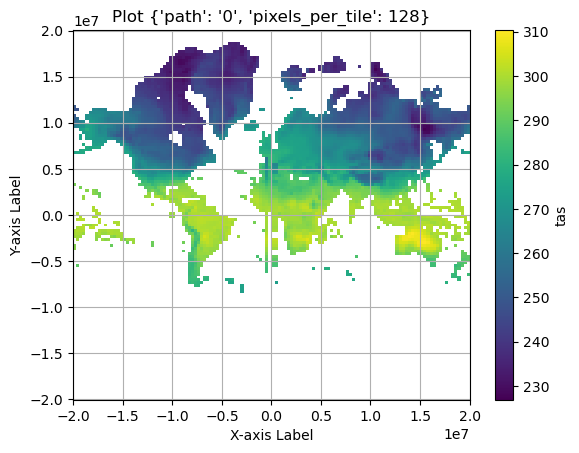

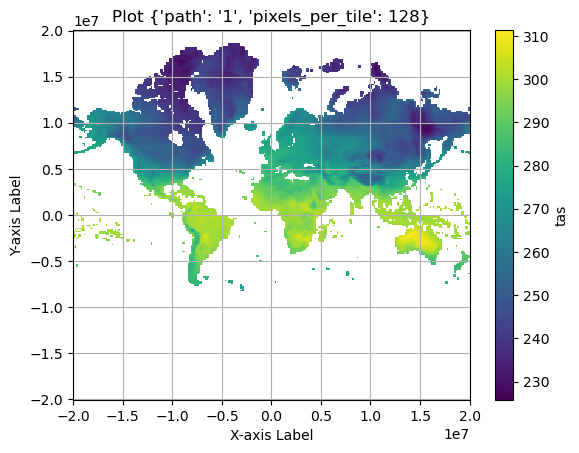

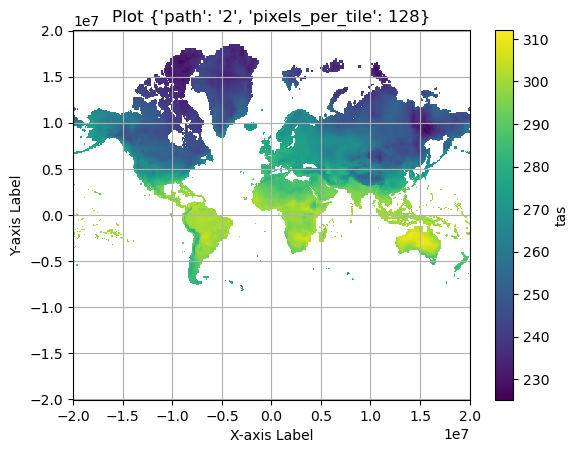

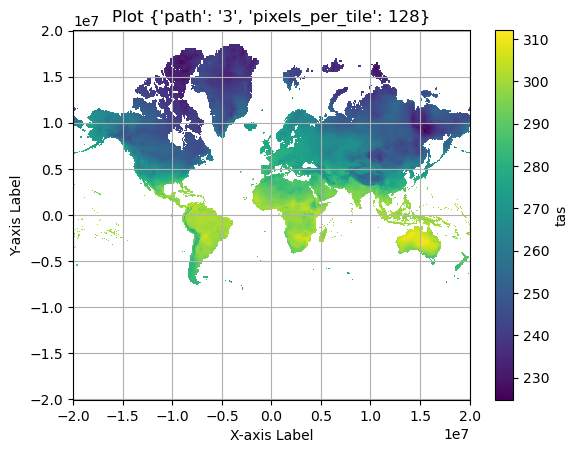

In [41]:
import matplotlib.pyplot as plt

pyramid_ds = xr.open_zarr(save_path, consolidated=True)
for path in pyramid_ds.multiscales[0]['datasets']:
    group = path['path']
    pyramid_group = xr.open_zarr(save_path, consolidated=True, group=group)
    zoom_zero = pyramid_group.isel(time=0)
    
    plt.figure()  # Create a new figure for each plot.
    zoom_zero.tas.plot()
    plt.title(f"Plot {path}")  # Set a title for each plot.
    plt.xlabel("X-axis Label")
    plt.ylabel("Y-axis Label")
    plt.grid(True)
    plt.show()